In this blog, we will learn to create custom regression analysis using `nn.Module`. Linear regression and Multi-Linear regression is one of the widely used machine learning algorithm. Regression analysis is predictive modelling technique which finds the relationship between a dependent (target) and independent variables (predictor). This technique is used for forecasting, time series modelling and finding the causal effect relationship between the variables.

Few examples where we can use the regression modelling

1. Forecasting the water consumption in an area based on population, temperature, humidity
2. Forecasting the temperature based on humidity, day (cloudy, sunny etc)
3. Forecasting the pollution generated by vehicle depending on engine power, vehicle model, year of purchase, average kilometer etc.


Below is the description of code.

In [1]:
# Import the necessary libraries 

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.tensor  as tensor
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [2]:
# Read data from the csv file at given location
data = pd.read_csv("./data/consumption.csv")

# Removing rows which corresponds to weekend. We are not predicting for weekend.
data = data[data.Weekend != 1]

# Droping column Date and Weekend
data = data.drop(["Date","Weekend"],axis=1)

# Consumption (Dependent Variable) is the column corresponds to the actual consumption of beer for a particular input.
# Separating the target dataset or actual values 
target = data["Consumption"]

# Independent Variables are the input for the linear regression model based on which it predicts the dependent variable.
# We are separating Independent variable here.
input_data = data.drop(["Consumption"],axis=1)

In [3]:
# Converting Dependent and Independent variable into tensor for further processing 
tensor_input = tensor(input_data.values,dtype=torch.double)
tensor_target = tensor(target.values,dtype=torch.double)

# Converting tensor_target for [n] size to [ n x 1]
px = pd.DataFrame(tensor_target)
tensor_target = torch.tensor(px.values,dtype=torch.double)

**TensorDataset**
TensorDataset is used to create Dataset wrapping tensors.

In [4]:
train_ds = TensorDataset(tensor_input, tensor_target)
train_ds[0:5]

(tensor([[27.3000, 23.9000, 32.5000,  0.0000],
         [27.0200, 24.5000, 33.5000,  0.0000],
         [23.8200, 21.0000, 28.3000,  0.0000],
         [23.7800, 20.1000, 30.5000, 12.2000],
         [24.0000, 19.5000, 33.7000,  0.0000]], dtype=torch.float64),
 tensor([[25.4610],
         [28.9720],
         [28.9000],
         [28.2180],
         [29.7320]], dtype=torch.float64))

**DataLoader**

It Combines a dataset and a sampler, and provides an iterable over the given dataset. The DataLoader supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning.

Below we have created a DataLoader object, we have passed  Dataset ,batch_size and booleab value for shuffle in the argument. Description for  arguments are given below
1. dataset (Dataset) : dataset from which to load the data.
2. batch_size (int, optional) : We define the sample for each batch. Defualt value is 1. It is important to have batch size of descent size. Too smaller batch size may lead to more iteration for getting the optimal solution. Batching will helps us for training dataset where we have limited resources ( memory, cpu ).
3. shuffle (bool, optional) : set to True to have the data reshuffled at every epoch. Default value of shuffle is false.

You can read more detail about DataLoader [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [5]:
# I have define a batch size of 20 as an example
batch_size = 20
train_dl = DataLoader(train_ds, batch_size, shuffle=True)


**Custom Linear Regression Model**

1. We can create custom linear_regression model by creating  subclass of nn.Module
2. nn.Module is base class for all neural network modules
3. PyTorch classes written in Python are executed by the forward() method of the class

Below, I have created model with name `linear_regression`

In [6]:

class linear_regression(nn.Module):
    
    #Constructor which accepts the input dataset size  and output dataset size
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    #PyTorch classes written in Python are executed by the forward() method of the class
    def forward(self, x):
        predicted_y = self.linear(x)
        return predicted_y

**Creating Object of the Model**
1. We have dependent variable Dataset of size (n x 4) and dependent varaible dataset of size (n x 1)
2. We can create object model by passing input_size=4 and output_size=1 in the model constructor
3. We can find the weight and bias value of the model by using the method `model.paramaeters()`
4. A state_dict is a Python dictionary object that maps each layer to its parameter tensor

In [7]:
model =linear_regression(4, 1)

In [8]:
print("The parameters: ", list(model.parameters()))

The parameters:  [Parameter containing:
tensor([[-0.4105,  0.3164,  0.3502,  0.4807]], requires_grad=True), Parameter containing:
tensor([-0.1599], requires_grad=True)]


In [9]:
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict([('linear.weight', tensor([[-0.4105,  0.3164,  0.3502,  0.4807]])), ('linear.bias', tensor([-0.1599]))])


**Optimizer**

In `torch.optim` package various optimizer algorithm has been defined. While constructing an Optimizer one have to give it an iterable containing the parameters to optimize. Then, One can specify optimizer-specific options such as the learning rate etc. 
Here, I have used Schotastic Gradient Descent algorithm. In this, we keep minimising the cost for each sample rather than cost average.

In [10]:
opt = optim.SGD(model.parameters(), lr=0.0006)

**Cost Function or Loss Function**

We have used mean squared error function for the cost evaluation.

In [11]:
loss_fn = nn.functional.mse_loss

**Training Model**

Below is training data fubction which accepts
1. Number of epochs
2. Object of the Linear Regression Model
3. Loss function 
4. Optimizer object to optimize parameters using Schotastic Gradient Descent

In [12]:
def training_function(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
         for input_batch,output_batch in train_dl:
            # Generate predictions
            pred = model(input_batch.float())
            loss = loss_fn(pred, output_batch.float())
            # Perform gradient descent
            loss.backward()
            # Optimizer to update the parameter
            opt.step()
            # zero_grad() will be used for making gradient from the previous calculation zero 
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(tensor_input.float()), tensor_target.float()))

**Calling the training function**

In [13]:
training_function(5000, model, loss_fn, opt)

Training loss:  tensor(16.4537, grad_fn=<MseLossBackward>)


**Prediction**

In [14]:
preds = model(tensor_input.float())
preds[0:5]

tensor([[24.3340],
        [25.0606],
        [21.8466],
        [22.5710],
        [25.4499]], grad_fn=<SliceBackward>)

In [15]:
tensor_target[0:5]

tensor([[25.4610],
        [28.9720],
        [28.9000],
        [28.2180],
        [29.7320]], dtype=torch.float64)

**Predicted Value Vs Actual Value**

Below is the graph showing the predicted values vs actual value.


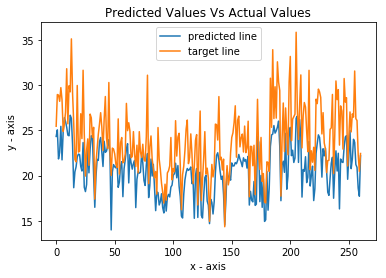

In [16]:
pred_line = preds.detach().numpy()
target_line =  tensor_target.detach().numpy()
plt.plot(pred_line,  label = "predicted line")
plt.plot(target_line,  label = "target line")
plt.xlabel('x - axis')
# Set the y axis label of the current axis.
plt.ylabel('y - axis')
# Set a title of the current axes.
plt.title('Predicted Values Vs Actual Values')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

**Conclusion**

We need to create custom liner regression model a lot in Pytorch. This example will help you in understanding the basics.

***Thank You***